## Problem Statement

Predict the onset of diabetes based on diagnostic measures

## Objective

The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

In [3]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline

In [4]:
# Reading datasets, one is normalised using Min-Max and one is normalised using Z-factor

dataset_z_score = pd.read_csv('../data/diabetes_z_score.csv')
dataset_min_max = pd.read_csv('../data/diabetes_min_max.csv')

## Feature description

**Pregnancies:** Number of times pregnant

**Plasma glucose:** concentration a 2 hours in an oral glucose tolerance test

**BloodPressure:** Diastolic blood pressure (mm Hg)

**SkinThickness:** Triceps skin fold thickness (mm)

**Insulin:** 2-Hour serum insulin (mu U/ml)

**BMI:** Body mass index (weight in kg/(height in m)^2)

**DiabetesPedigreeFunction:** Diabetes pedigree function (liklihood of diabetes based on family history)

**Age:** Age (years)

**Outcome:** Class variable (0 or 1) 268 of 768 are 1, the others are 0

In [5]:
features_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 
                    'DiabetesPedigreeFunction', 'Age']

## Data Normalisation process

1. Normalised all the values using Z-factor scaling [(Value-mean)/standard_deviation]
2. Normalised all the values using Min-Max scaling as well [(Value-min)/(max-min)]
3. We used 3 distance metrics to compare:
    > Manhattan Distance
    
    > Euclidean Distance
    
    > Cosine Similarity (used negative of it so that low value means high similarity)
    
4. Shuffled the data and then broke the data points into three set:
5. Training set: Used as training data set
6. Test set: Used to find the optimum value of K
7. Holdout set: Used to predict the accuracy using the optimum value of K

#### Description of normalisation is provided in the preprocessing notebook present in the same directory.

In [6]:
# Visualizing dataset normalised using Min-Max scaling

dataset_min_max

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.079086,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.079086,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.147135,0.079086,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.367742,0.530612,0.445652,0.199519,0.300613,0.039710,0.700000,0
764,0.117647,0.503226,0.469388,0.217391,0.079086,0.380368,0.111870,0.100000,0
765,0.294118,0.496774,0.489796,0.173913,0.117788,0.163599,0.071307,0.150000,0
766,0.058824,0.529032,0.367347,0.147135,0.079086,0.243354,0.115713,0.433333,1


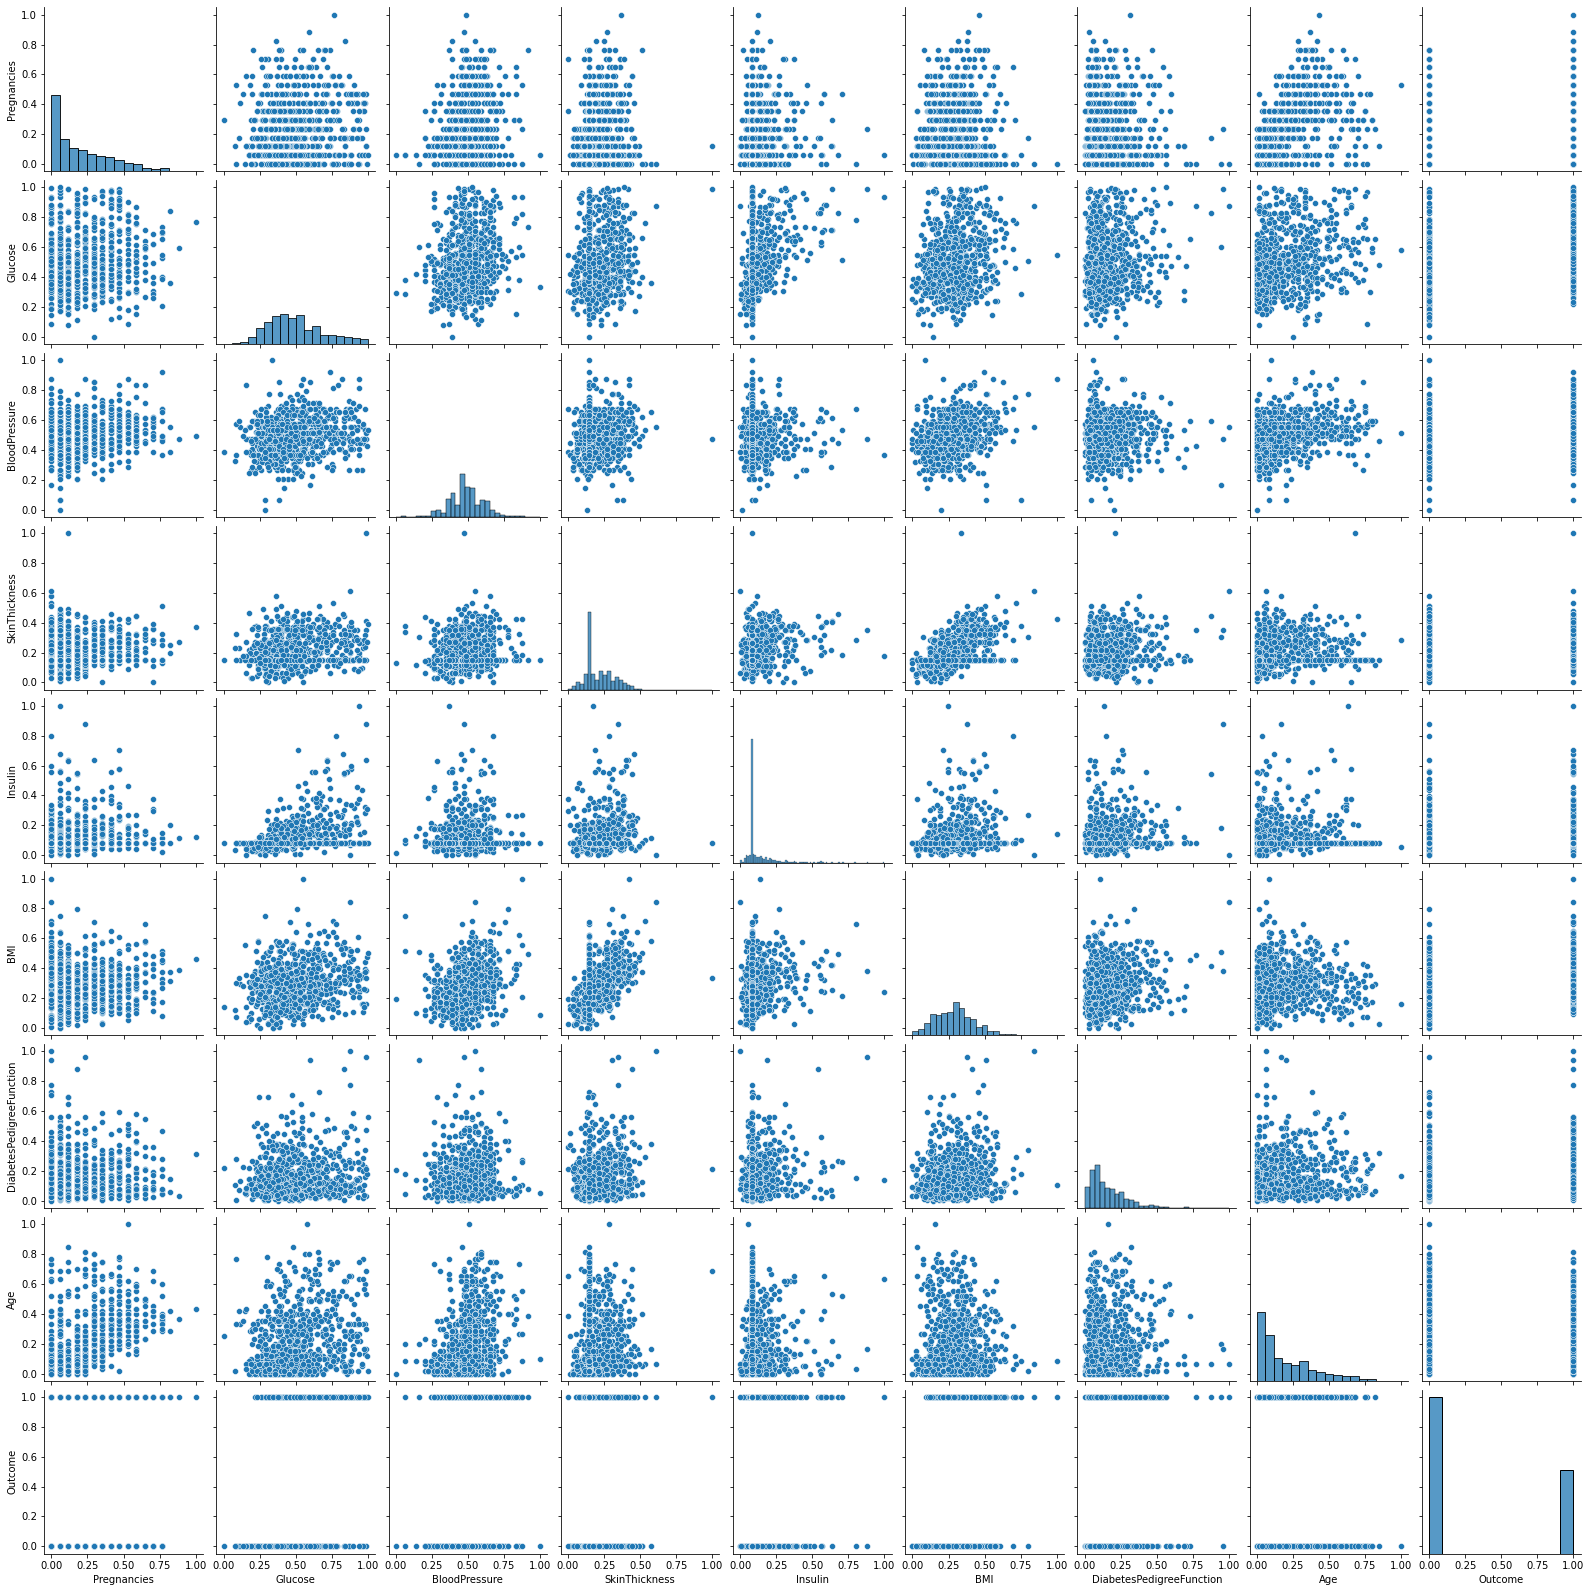

In [7]:
sns.pairplot(dataset_min_max)

In [8]:
# Visualizing dataset normalised using Z-factor scaling

dataset_z_score

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639530,0.864712,-0.021031,0.871489,-0.417496,0.167147,0.468187,1.425067,1
1,-0.844335,-1.205204,-0.516246,0.248516,-0.417496,-0.850980,-0.364823,-0.190548,0
2,1.233077,2.014666,-0.681318,-0.630243,-0.417496,-1.330954,0.604004,-0.105515,1
3,-0.844335,-1.073781,-0.516246,-0.374456,-0.264934,-0.632810,-0.920163,-1.040871,0
4,-1.141108,0.503298,-2.662181,0.871489,0.530078,1.548890,5.481337,-0.020483,1
...,...,...,...,...,...,...,...,...,...
763,1.826623,-0.679511,0.309113,2.221263,0.658999,0.065334,-0.908090,2.530487,0
764,-0.547562,0.010461,-0.186103,0.040859,-0.417496,0.632576,-0.398023,-0.530677,0
765,0.342757,-0.022395,-0.021031,-0.374456,-0.071553,-0.909159,-0.684747,-0.275580,0
766,-0.844335,0.141884,-1.011462,-0.630243,-0.417496,-0.341917,-0.370859,1.169970,1


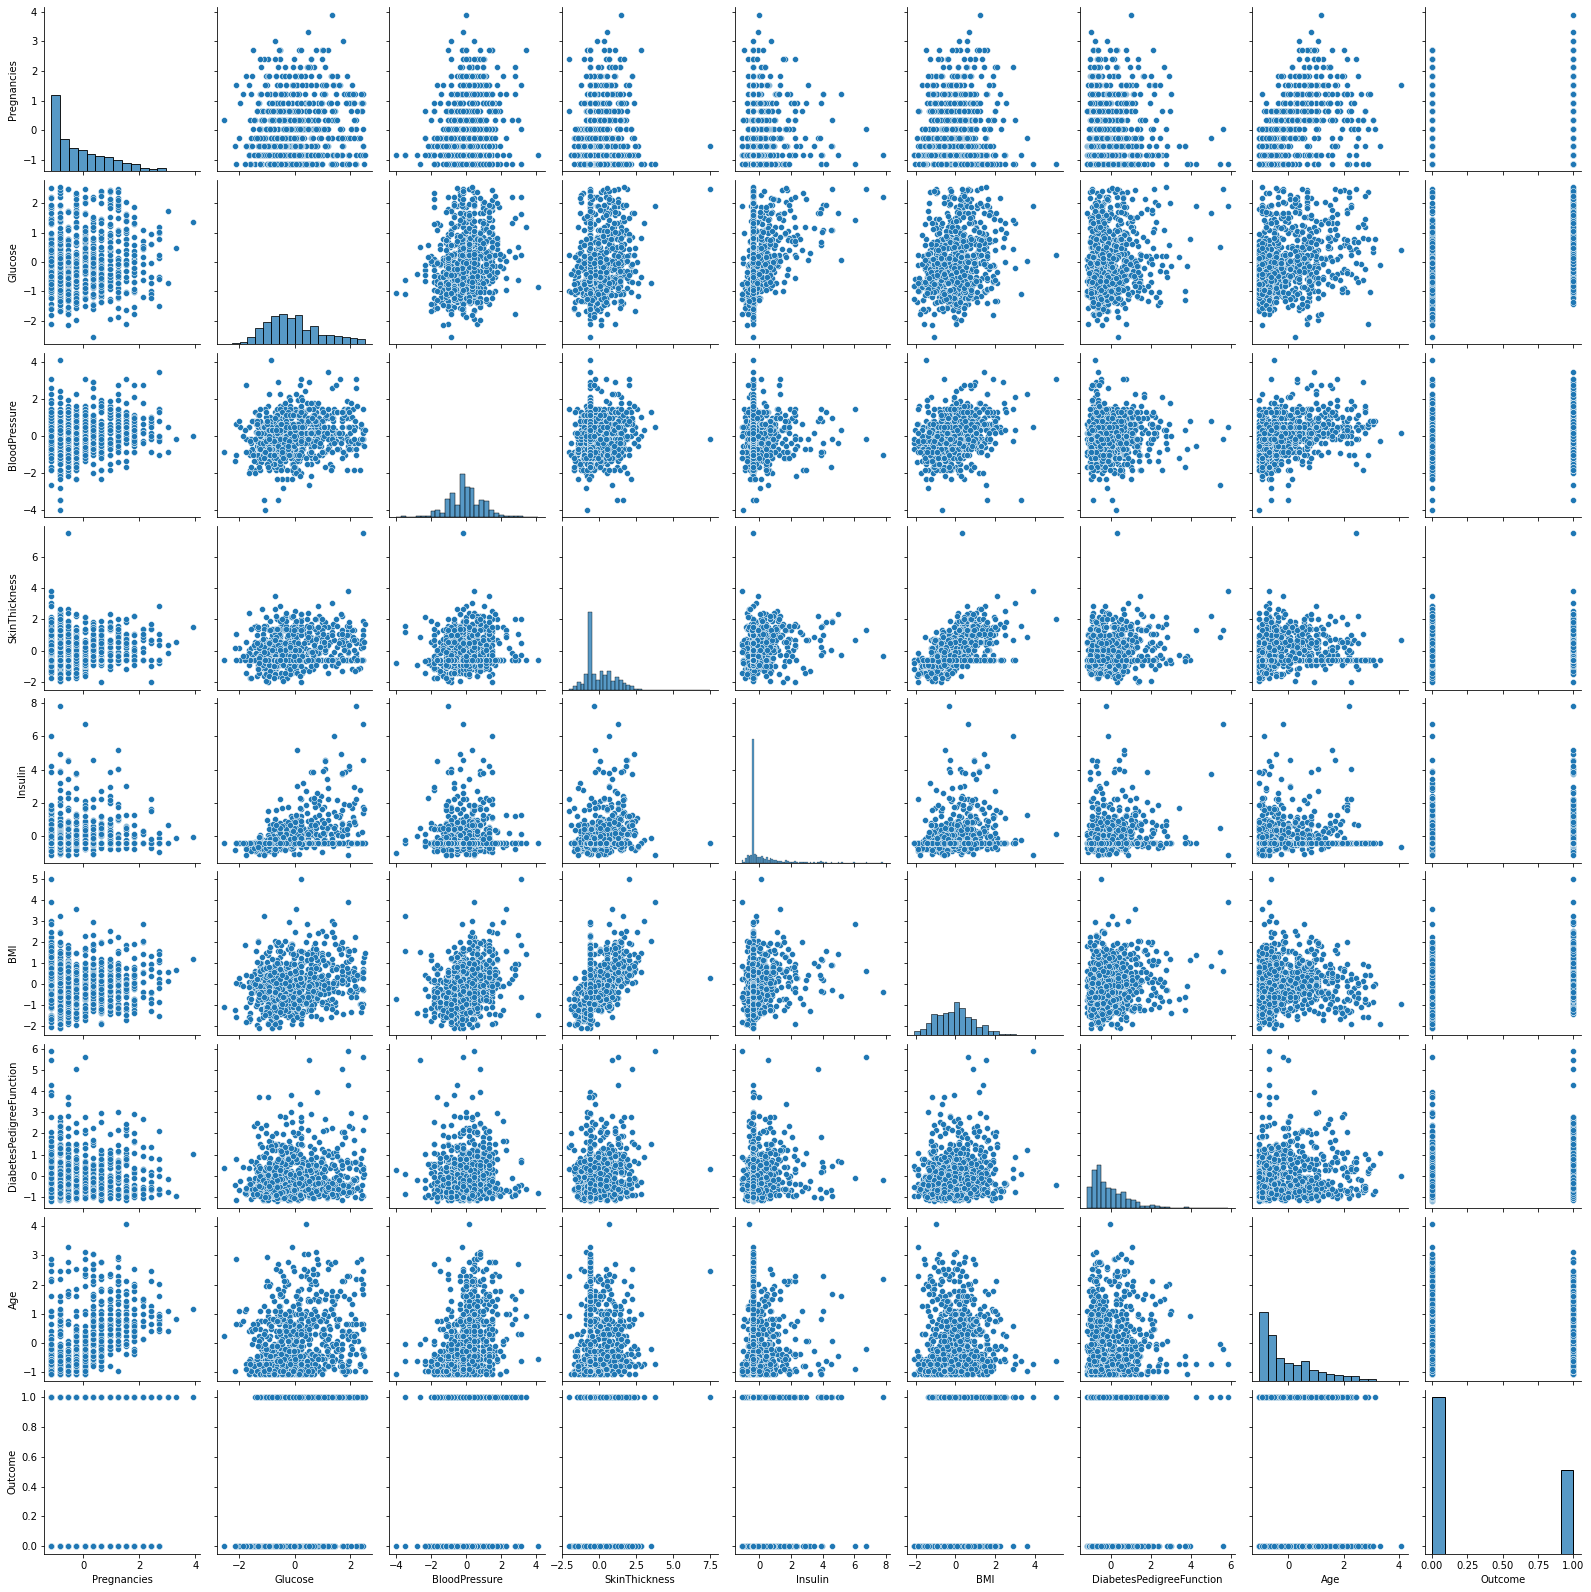

In [9]:
sns.pairplot(dataset_z_score)

In [10]:
# Splitting the dataset into test, trainign and holout dataset using the ration passed from below functions

def train_test_holdout_split(data, test_data_ratio, holdout_data_ratio):
    rows, _ = data.shape
    test_data_size = int(test_data_ratio * rows)
    holdout_data_size = int(holdout_data_ratio * rows)
    
    data = data.sample(frac=1)
    
    test_data = data[:test_data_size]
    holdout_data = data[test_data_size:holdout_data_size + test_data_size]
    train_data = data[holdout_data_size + test_data_size:]
    
    return (train_data, test_data, holdout_data)

## KNN implementation

### Basic implementation of KNN with two distance metrics (Manhattan and Euclidean)

In [11]:
import math

In [12]:
# Calculating exclidean distance

def euclideanDistance(point1, point2):
    totalDistance = 0.0
    totalFeatures = len(point1)
    for i in range(totalFeatures):
        totalDistance = totalDistance + (point1[i]-point2[i])**2
        
    return math.sqrt(totalDistance)

In [13]:
# Calculating Manhattan distance

def manhattanDistance(point1, point2):
    totalDistance = 0.0
    totalFeatures = len(point1)
    for i in range(totalFeatures):
        totalDistance = totalDistance + abs(point1[i]-point2[i])
        
    return math.sqrt(totalDistance)

In [14]:
# Calculating Cosine Similarity distance

def cosineSimilarity(point1, point2):
    dotProduct = np.dot(point1, point2)
    norm1 = np.linalg.norm(point1)
    norm2 = np.linalg.norm(point2)
    
    # we will return negative of similarity because our sorter function assumes two points are closer if distance
    # metric is less between them whereas in cosine similarity 1 means same, 0 means orthogonal
    
    similarity = dotProduct/(norm1*norm2)
    
    return -similarity

In [15]:
# KNN implemntation

def knn(k, trainData, trainLabels, testData, distanceMetric):

    testDataPredictions = []
    for testPoint in testData.itertuples(index=False):
        allDistancesFromPoint = []
        i=0
        for trainPoint in trainData.itertuples(index=False):
            if distanceMetric == 2:
                distance = euclideanDistance(trainPoint, testPoint)
                allDistancesFromPoint.append((distance, trainLabels.iloc[i]))
            elif distanceMetric == 1:
                distance = manhattanDistance(trainPoint, testPoint)
                allDistancesFromPoint.append((distance, trainLabels.iloc[i]))
            elif distanceMetric == 3:
                distance = cosineSimilarity(trainPoint, testPoint)
                allDistancesFromPoint.append((distance, trainLabels.iloc[i]))
            else:
                raise Exception("Incorrest distance metric passed. Only values [1,2] allowed")
            i+=1
            
        allDistancesFromPoint.sort(key = lambda x: x[0])
        
        labelCounter = {}
        for i in range(k):
            if allDistancesFromPoint[i][1] in labelCounter:
                labelCounter[allDistancesFromPoint[i][1]]+=1
            else:
                labelCounter[allDistancesFromPoint[i][1]]=1
        predictedLabel = max(labelCounter, key=labelCounter.get)
        testDataPredictions.append(predictedLabel)
        
    return testDataPredictions

In [16]:
# Calculating accuracy using predicted labels and actual labels

def calCulateAccuracy(predictedValuesForTestData, realLabelsOfTestData):
    total = len(predictedValuesForTestData)
    correct = 0
    for i in range(len(predictedValuesForTestData)):
        if predictedValuesForTestData[i] == realLabelsOfTestData.iloc[i]:
            correct+=1
        
    return (correct/total)*100.0

In [17]:
# Creating the confusion matrix using predicted and actual values

def confusionMatrix(predictedValues, actualValues):
    matrix = [[0,0],[0,0]]
    for i in range(len(predictedValues)):
        if predictedValues[i] == actualValues.iloc[i] and predictedValues[i] == 1:
            matrix[0][0]+=1
        elif predictedValues[i] == actualValues.iloc[i] and predictedValues[i] == 0:
            matrix[1][1]+=1
        elif predictedValues[i] != actualValues.iloc[i] and predictedValues[i] == 1:
            matrix[0][1]+=1
        else:
            matrix[1][0]+=1
    return matrix

### Analysis of dataset normalised using Min-Max values

In [18]:
train_data_min_max, test_data_min_max, holdout_data_min_max = train_test_holdout_split(dataset_min_max, 0.2, 0.2)

In [19]:
train_data_min_max_features = train_data_min_max[features_columns]
train_data_min_max_labels = train_data_min_max.Outcome

test_data_min_max_features = test_data_min_max[features_columns]
test_data_min_max_labels = test_data_min_max.Outcome

holdout_data_min_max_features = holdout_data_min_max[features_columns]
holdout_data_min_max_labels = holdout_data_min_max.Outcome

In [20]:
valueOfK_minmax = []
accuracyForGivenK_usingManhattan_minmax = []
accuracyForGivenK_usingEuclidean_minmax = []
accuracyForGivenK_usingCosineSim_minmax = []

for i in range(1,20):
    valueOfK_minmax.append(i)
    predictedValuesForTestData_Manhattan_minmax = knn(i,train_data_min_max_features, train_data_min_max_labels, test_data_min_max_features, 1)
    predictedValuesForTestData_Euclidean_minmax = knn(i,train_data_min_max_features, train_data_min_max_labels, test_data_min_max_features, 2)
    predictedValuesForTestData_CosineSim_minmax = knn(i,train_data_min_max_features, train_data_min_max_labels, test_data_min_max_features, 3)
    accuracyForGivenK_usingManhattan_minmax.append(calCulateAccuracy(predictedValuesForTestData_Manhattan_minmax, train_data_min_max_labels))
    accuracyForGivenK_usingEuclidean_minmax.append(calCulateAccuracy(predictedValuesForTestData_Euclidean_minmax, train_data_min_max_labels))
    accuracyForGivenK_usingCosineSim_minmax.append(calCulateAccuracy(predictedValuesForTestData_CosineSim_minmax, train_data_min_max_labels))


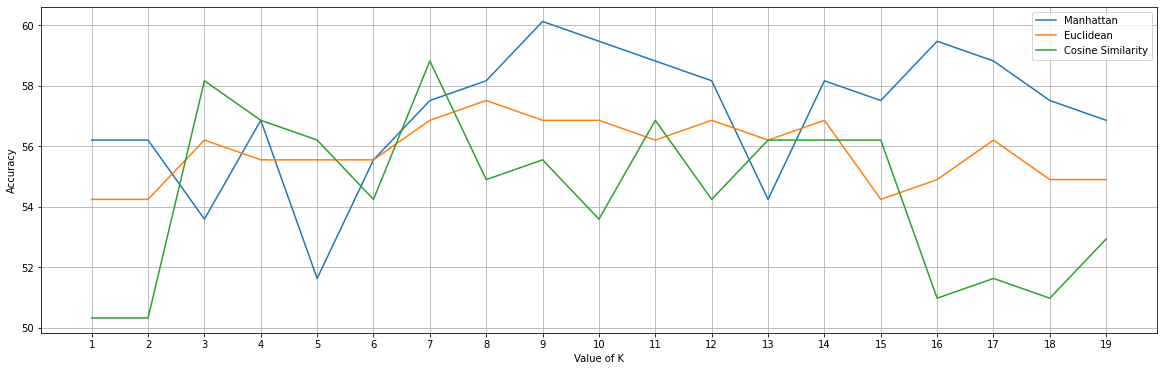

In [21]:
dataframe_MinMax = pd.DataFrame()
dataframe_MinMax['K'] = valueOfK_minmax
dataframe_MinMax['Manhattan'] = accuracyForGivenK_usingManhattan_minmax
dataframe_MinMax['Euclidean'] = accuracyForGivenK_usingEuclidean_minmax
dataframe_MinMax['CosineSim'] = accuracyForGivenK_usingCosineSim_minmax
plt.figure(figsize=(20,6))
plt.xticks(valueOfK_minmax)
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
sns.lineplot(data=dataframe_MinMax, x='K', y='Manhattan', label='Manhattan')
sns.lineplot(data=dataframe_MinMax, x='K', y='Euclidean', label='Euclidean')
sns.lineplot(data=dataframe_MinMax, x='K', y='CosineSim', label='Cosine Similarity')
plt.grid()

#### Accuracy scores and confusion matrix for unseen holdout data using optimum value of K using above graph 

In [22]:
predictedValuesForHoldoutData_minmax_manhattan = knn(9, train_data_min_max_features, train_data_min_max_labels, holdout_data_min_max_features, 1)
predictedValuesForHoldoutData_minmax_euclidean = knn(8, train_data_min_max_features, train_data_min_max_labels, holdout_data_min_max_features, 2)
predictedValuesForHoldoutData_minmax_cosinesim = knn(7, train_data_min_max_features, train_data_min_max_labels, holdout_data_min_max_features, 3)

print("Accuracy using Manhattan distance for K=9 is: ", calCulateAccuracy(predictedValuesForHoldoutData_minmax_manhattan, holdout_data_min_max_labels))
print("Confusion matrix when using Manhattan distance: ", confusionMatrix(predictedValuesForHoldoutData_minmax_manhattan, holdout_data_min_max_labels))
print("-----------------------------------------------------------------------")
print("Accuracy using Euclidean distance for K=8 is: ", calCulateAccuracy(predictedValuesForHoldoutData_minmax_euclidean, holdout_data_min_max_labels))
print("Confusion matrix when using Euclidean distance: ", confusionMatrix(predictedValuesForHoldoutData_minmax_euclidean, holdout_data_min_max_labels))
print("-----------------------------------------------------------------------")
print("Accuracy using Cosine Similarity distance for K=7 is: ", calCulateAccuracy(predictedValuesForHoldoutData_minmax_cosinesim, holdout_data_min_max_labels))
print("Confusion matrix when using Cosine Similarity distance: ", confusionMatrix(predictedValuesForHoldoutData_minmax_cosinesim, holdout_data_min_max_labels))


Accuracy using Manhattan distance for K=9 is:  75.81699346405229
Confusion matrix when using Manhattan distance:  [[28, 16], [21, 88]]
-----------------------------------------------------------------------
Accuracy using Euclidean distance for K=8 is:  76.47058823529412
Confusion matrix when using Euclidean distance:  [[27, 14], [22, 90]]
-----------------------------------------------------------------------
Accuracy using Cosine Similarity distance for K=7 is:  71.89542483660131
Confusion matrix when using Cosine Similarity distance:  [[28, 22], [21, 82]]


### Analysis of dataset normalised using Z-factor values

In [23]:
train_data_z_score, test_data_z_score, holdout_data_z_score = train_test_holdout_split(dataset_z_score, 0.2, 0.2)

In [24]:
train_data_z_score_features = train_data_z_score[features_columns]
train_data_z_score_labels = train_data_z_score.Outcome

test_data_z_score_features = test_data_z_score[features_columns]
test_data_z_score_labels = test_data_z_score.Outcome

holdout_data_z_score_features = holdout_data_z_score[features_columns]
holdout_data_z_score_labels = holdout_data_z_score.Outcome

In [25]:
valueOfK_Zfactor = []
accuracyForGivenK_usingManhattan_Zfactor = []
accuracyForGivenK_usingEuclidean_Zfactor = []
accuracyForGivenK_usingCosineSim_Zfactor = []

for i in range(1,20):
    valueOfK_Zfactor.append(i)
    predictedValuesForTestData_Manhattan_Zfactor = knn(i,train_data_z_score_features, train_data_z_score_labels, test_data_z_score_features, 1)
    predictedValuesForTestData_Euclidean_Zfactor = knn(i,train_data_z_score_features, train_data_z_score_labels, test_data_z_score_features, 2)
    predictedValuesForTestData_CosineSim_Zfactor = knn(i,train_data_z_score_features, train_data_z_score_labels, test_data_z_score_features, 3)
    accuracyForGivenK_usingManhattan_Zfactor.append(calCulateAccuracy(predictedValuesForTestData_Manhattan_Zfactor, train_data_z_score_labels))
    accuracyForGivenK_usingEuclidean_Zfactor.append(calCulateAccuracy(predictedValuesForTestData_Euclidean_Zfactor, train_data_z_score_labels))
    accuracyForGivenK_usingCosineSim_Zfactor.append(calCulateAccuracy(predictedValuesForTestData_CosineSim_Zfactor, train_data_z_score_labels))


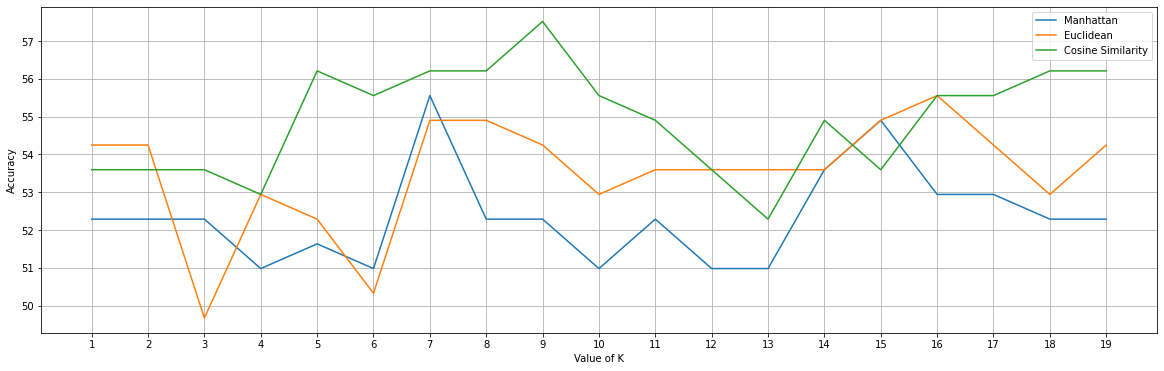

In [26]:
dataframe_Zfactor = pd.DataFrame()
dataframe_Zfactor['K'] = valueOfK_Zfactor
dataframe_Zfactor['Manhattan'] = accuracyForGivenK_usingManhattan_Zfactor
dataframe_Zfactor['Euclidean'] = accuracyForGivenK_usingEuclidean_Zfactor
dataframe_Zfactor['CosineSim'] = accuracyForGivenK_usingCosineSim_Zfactor
plt.figure(figsize=(20,6))
plt.xticks(valueOfK_Zfactor)
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
sns.lineplot(data=dataframe_Zfactor, x='K', y='Manhattan', label='Manhattan')
sns.lineplot(data=dataframe_Zfactor, x='K', y='Euclidean', label='Euclidean')
sns.lineplot(data=dataframe_Zfactor, x='K', y='CosineSim', label='Cosine Similarity')
plt.grid()

#### Accuracy scores and confusion matrix for unseen holdout data using optimum value of K using above graph

In [27]:
predictedValuesForHoldoutData_zfactor_manhattan = knn(7, train_data_min_max_features, train_data_min_max_labels, holdout_data_z_score_features, 1)
predictedValuesForHoldoutData_zfactor_euclidean = knn(16, train_data_z_score_features, train_data_z_score_labels, holdout_data_z_score_features, 2)
predictedValuesForHoldoutData_zfactor_cosinesim = knn(9, train_data_min_max_features, train_data_min_max_labels, holdout_data_z_score_features, 3)

print("Accuracy using Manhattan distance for K=7 is: ", calCulateAccuracy(predictedValuesForHoldoutData_zfactor_manhattan, holdout_data_z_score_labels))
print("Confusion matrix when using Manhattan distance: ", confusionMatrix(predictedValuesForHoldoutData_zfactor_manhattan, holdout_data_z_score_labels))
print("-----------------------------------------------------------------------")
print("Accuracy using Euclidean distance for K=16 is: ", calCulateAccuracy(predictedValuesForHoldoutData_zfactor_euclidean, holdout_data_z_score_labels))
print("Confusion matrix when using Euclidean distance: ", confusionMatrix(predictedValuesForHoldoutData_zfactor_euclidean, holdout_data_z_score_labels))
print("-----------------------------------------------------------------------")
print("Accuracy using Cosine Similarity distance for K=9 is: ", calCulateAccuracy(predictedValuesForHoldoutData_zfactor_cosinesim, holdout_data_z_score_labels))
print("Confusion matrix when using Cosine Similarity distance: ", confusionMatrix(predictedValuesForHoldoutData_zfactor_cosinesim, holdout_data_z_score_labels))
print("-----------------------------------------------------------------------")


Accuracy using Manhattan distance for K=7 is:  72.54901960784314
Confusion matrix when using Manhattan distance:  [[21, 6], [36, 90]]
-----------------------------------------------------------------------
Accuracy using Euclidean distance for K=16 is:  74.50980392156863
Confusion matrix when using Euclidean distance:  [[28, 10], [29, 86]]
-----------------------------------------------------------------------
Accuracy using Cosine Similarity distance for K=9 is:  64.05228758169935
Confusion matrix when using Cosine Similarity distance:  [[5, 3], [52, 93]]
-----------------------------------------------------------------------


## Runtime

1. The time depends on the distance metrics which is being used to get the result.
2. Since, we are comparing all the test points to training points the complexity grows with in align with O(n^2) where n is the number of samples we have.
3. If we have number of features close to number of points, then the time complexity can even grow to O(n^3)
4. The size of holdout data to calculate runtime is around 160 data points.
